<a href="https://colab.research.google.com/github/sk27110/AutoPriceForecast/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [86]:
df = pd.read_csv('full_cars_data.csv')

In [87]:
df.shape

(206656, 9)

In [88]:
df.head()

,price,title,year,mileage,engine,transmission,body_type,drive_type,color
0,NaN,Mercedes-Benz G-Класс 230 II (W463),1990,197000км,2.3 л / 125 л.с. / Бензин,автомат,внедорожник 3 дв.,полный,серый
1,NaN,Mercedes-Benz S-Класс 560 II (W126) Рестайлинг,1990,2800км,5.6 л / 279 л.с. / Бензин,автомат,седан,задний,коричневый
2,NaN,Toyota Carina V (T170),1990,300000км,1.6 л / 98 л.с. / Бензин,автомат,седан,передний,синий
3,189 700 ₽,Volkswagen Passat B3,1990,325000км,1.8 л / 90 л.с. / Бензин,механика,универсал 5 дв.,передний,красный
4,370 000 ₽,Nissan Terrano I,1990,224000км,2.7 л / 100 л.с. / Дизель,автомат,внедорожник 5 дв.,полный,зелёный


Целевая переменная здесь -- price.

Как мы видим, в колонке price есть пропуски. Давайте удалим все строки, в которых price = NaN

In [89]:
df = df.dropna(subset=['price'])

In [90]:
df['price'].isna().sum()

0

Теперь пропусков в price у нас нет.

Давайте посмотрим, какие единицы измерения есть в столбцах:

In [91]:
print("Различные валюты:", df['price'].apply(lambda x: re.sub(r'[\d\s]+', '', x)).unique())
print("Различные единицы измерения расстояния:", df['mileage'].apply(lambda x: re.sub(r'[\d\s]+', '', x)).unique())
print("Различные единицы измерения двигателя:", df['engine'].apply(lambda x: re.sub(r'[\d\s]+', '', x)).unique())

Различные валюты: ['₽']
Различные единицы измерения расстояния: ['км']
Различные единицы измерения двигателя: ['.л/л.с./Бензин' '.л/л.с./Дизель' '.л/л.с./Газ' '.л/л.с./Гибрид'
 'л.с./кВт/Электро']


Как мы видим, с price и mileage все хорошо, а вот с engine придется поработать.

Теперь обработаем параметр engine. Как мы видим, в нем одновременно указан объем, мощьность и вид топлива. Разобъем его на три колонки.

In [92]:
df['engine_capacity'] = np.nan
df['engine_power'] = np.nan
df['fuel_type'] = np.nan

In [93]:
def engine_transform(row):
  try:
    if pd.isna(row['engine']):
      return row
    data = row['engine'].split('/')
    if data[2].strip() == 'Электро':
      data[1] = data[0]
      data[0] = np.nan

    row['engine_capacity'] = data[0]
    row['engine_power'] = data[1]
    row['fuel_type'] = data[2].strip()
    return row
  except:
    print("Ошибка со строкой", row)
    return row

In [94]:
df = df.apply(engine_transform, axis=1)

In [95]:
print(df['engine_capacity'].isna().sum())
print(df['engine_power'].isna().sum())
print(df['fuel_type'].isna().sum())

3606
0
0


Как мы видим, пропусков в новых столбцах нет.

Теперь удалим ненужный столбец engine:

In [96]:
df = df.drop('engine', axis=1)

In [97]:
df.head()

,price,title,year,mileage,transmission,body_type,drive_type,color,engine_capacity,engine_power,fuel_type
3,189 700 ₽,Volkswagen Passat B3,1990,325000км,механика,универсал 5 дв.,передний,красный,1.8 л,90 л.с.,Бензин
4,370 000 ₽,Nissan Terrano I,1990,224000км,автомат,внедорожник 5 дв.,полный,зелёный,2.7 л,100 л.с.,Дизель
5,350 000 ₽,Honda Civic IV,1990,200000км,механика,седан,передний,серебристый,1.6 л,120 л.с.,Бензин
6,360 000 ₽,Volkswagen Passat B3,1990,200000км,механика,универсал 5 дв.,передний,белый,1.8 л,90 л.с.,Бензин
7,99 000 ₽,Toyota Carina V (T170),1990,296000км,автомат,седан,передний,серебристый,1.5 л,94 л.с.,Бензин


В столбец transmission при скрапинге попали данные о дальности хода для электромобилей. Давайте извлечем их оттуда.

In [98]:
import re

df['travel_distance'] = 0


def transmission_transform(row):
  try:
    if pd.isna(row['transmission']):
      return row
    if row['fuel_type'] == 'Электро':
      number = re.findall(r'\d+', row['transmission'])
      if number:
        row['travel_distance'] = int(number[0])
        row['transmission'] = 'none'
        return row
    return row
  except:
    print(row['transmission'])
    return row


df = df.apply(transmission_transform, axis=1)

Посмотрим, какие единицы измерения есть в числовых столбцах, чтобы правильно преобразовать данные:

In [99]:
print("Различные валюты:", df['price'].apply(lambda x: np.nan if pd.isna(x) else re.sub(r'[\d\s]+', '', x)).unique())
print("Различные единицы измерения расстояния:", df['mileage'].apply(lambda x: np.nan if pd.isna(x) else re.sub(r'[\d\s]+', '', x)).unique())
print("Различные единицы измерения объема двигателя:", df['engine_capacity'].apply(lambda x: np.nan if pd.isna(x) else re.sub(r'[\d\s]+', '', x)).unique())
print("Различные единицы измерения мощьности:", df['engine_power'].apply(lambda x: np.nan if pd.isna(x) else re.sub(r'[\d\s]+', '', x)).unique())

Различные валюты: ['₽']
Различные единицы измерения расстояния: ['км']
Различные единицы измерения объема двигателя: ['.л' nan]
Различные единицы измерения мощьности: ['л.с.']


Преобразуем цену в числовую переменную.

In [100]:
def price_to_int(x):
  if pd.isna(x):
    return np.nan
  return int(x.replace('\xa0', "").replace("₽", ""))


In [101]:
df['price'] = df['price'].apply(price_to_int)

Теперь price -- числовая переменная типа int, единица измерения -- рубли.

Преобразуем mileage в числовой формат.

In [102]:
def mileage_to_int(x):
  if pd.isna(x):
    return np.nan
  return int(x.replace('км', '').replace('\xa0', ""))

In [103]:
df['mileage'] = df['mileage'].apply(mileage_to_int)

Теперь mileage -- числовая переменная, единица измерения -- километры.

In [104]:
def engine_capacity_to_int(x):
  if pd.isna(x):
    return np.nan
  return float(x.replace('л', '').strip())

In [105]:
df['engine_capacity'] = df['engine_capacity'].apply(engine_capacity_to_int)

Теперь engine_capacity -- числовая переменная, единицы измерения -- литры.

Преобразуем engine_power в числовой формат.

In [106]:
def engine_power_to_int(x):
  if pd.isna(x):
    return np.nan
  return float(x.replace('л.с.', '').strip())

In [107]:
df['engine_power'] = df['engine_power'].apply(engine_power_to_int)

Теперь engine_power -- числовая переменная, единицы измерения -- лошадиные силы.

In [108]:
df.dtypes

,0
price,int64
title,object
year,int64
mileage,int64
transmission,object
body_type,object
drive_type,object
color,object
engine_capacity,float64
engine_power,float64


Посмотрим на основные статистики наших данных.

In [109]:
df.describe(include='number')

,price,year,mileage,engine_capacity,engine_power,travel_distance
count,1.991820e+05,199182.000000,199182.000000,195576.000000,199182.000000,199182.000000
mean,2.305377e+06,2010.537955,175138.229825,2.315878,188.135630,9.560417
std,5.746065e+06,8.737646,118841.182301,0.899047,110.511373,72.873968
min,2.500000e+04,1990.000000,1.000000,0.400000,10.000000,0.000000
25%,5.600000e+05,2004.000000,81000.000000,1.600000,116.000000,0.000000
50%,1.200000e+06,2011.000000,170000.000000,2.000000,155.000000,0.000000
75%,2.500000e+06,2018.000000,250000.000000,2.700000,231.000000,0.000000
max,1.000000e+09,2025.000000,1000000.000000,8.300000,1548.000000,1055.000000


Как мы видим, отрицательных значений в данных нет. Экстремально больших значений в данных тоже нет.

In [110]:
df.describe(include='object')

,title,transmission,body_type,drive_type,color,fuel_type
count,199182,199182,199182,199182,199176,199182
unique,8182,5,28,3,16,5
top,Lada (ВАЗ) 2110,автомат,внедорожник 5 дв.,полный,чёрный,Бензин
freq,1130,112515,83983,91939,48846,157290


Давайте посмотрим на уникальные значения в данных:

Посмотрим, есть ли в данных пропуски.

In [111]:
df.isna().sum()

,0
price,0
title,0
year,0
mileage,0
transmission,0
body_type,0
drive_type,0
color,6
engine_capacity,3606
engine_power,0


Посмотрим на процент пропусков в данных:

In [112]:
df.isna().mean()*100

,0
price,0.000000
title,0.000000
year,0.000000
mileage,0.000000
transmission,0.000000
body_type,0.000000
drive_type,0.000000
color,0.003012
engine_capacity,1.810405
engine_power,0.000000


Пропущенные значения в engine_capacity -- это данные, в которых тип двигателя -- Электро. У такого двигателя нет объема.

Пропусков в цвете всего 5, скорее всего их не указал продавец или при скрапинге страница не успела прогрузить цвет.

In [113]:
df[df['fuel_type'] == 'Электро'].shape

(3606, 12)

color мы заполним самым популярным значением.


In [114]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
df['color'] = imputer.fit_transform(df[['color']]).ravel()

In [115]:
df['color'].isna().sum()

0

Теперь заполним все пропуски в engine_capacity нулями

In [116]:
df['engine_capacity'] = df['engine_capacity'].fillna(0)

In [117]:
df['engine_capacity'].isna().sum()

0

In [118]:
df.isna().sum().sum()

0

Построим boxplot для всех числовых признаков, чтобы посмотреть на распределение данных (на travel_distance посмотрим потом, так там большинство нулей).

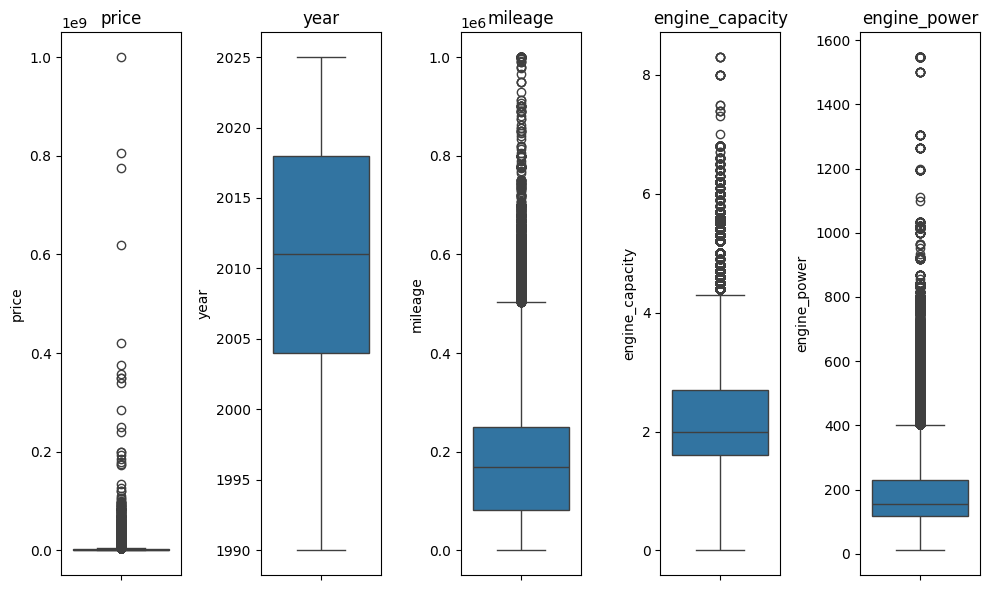

In [119]:
plt.figure(figsize=(10, 6))

cols = ['price', 'year', 'mileage', 'engine_capacity', 'engine_power']

for i, col in enumerate(cols):
    plt.subplot(1, len(cols), i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

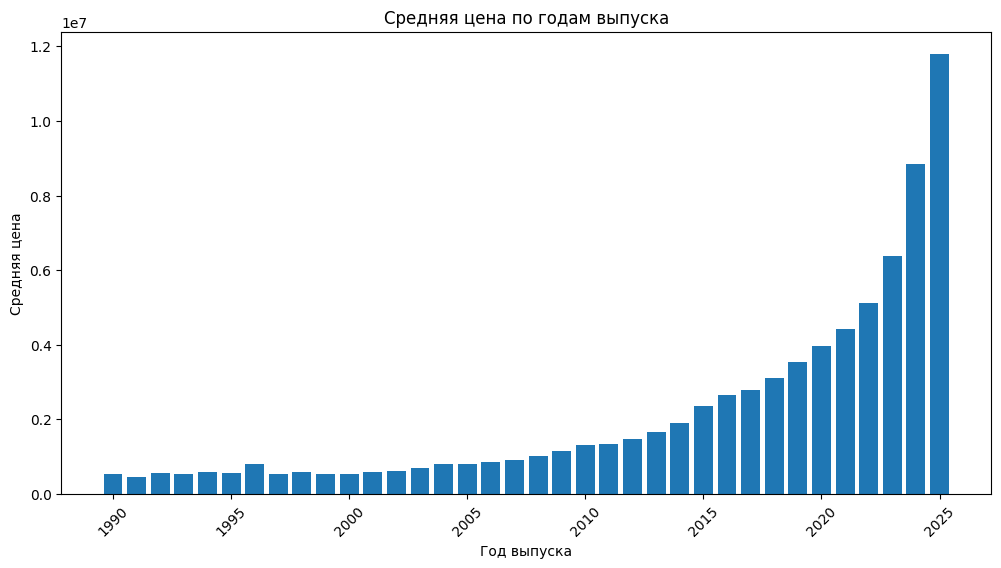

In [120]:
year_price = df.groupby('year')['price'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(year_price['year'], year_price['price'])
plt.title('Средняя цена по годам выпуска')
plt.xlabel('Год выпуска')
plt.ylabel('Средняя цена')
plt.xticks(rotation=45)
plt.show()

Получаем совершенно ожидаемое распределение цены в зависимости от года выпуска. Так, как в наших данных учитывается динамика рынка за долгий период, вероятность переобучения и неточных прогнозов в будущем из-за этого мала&

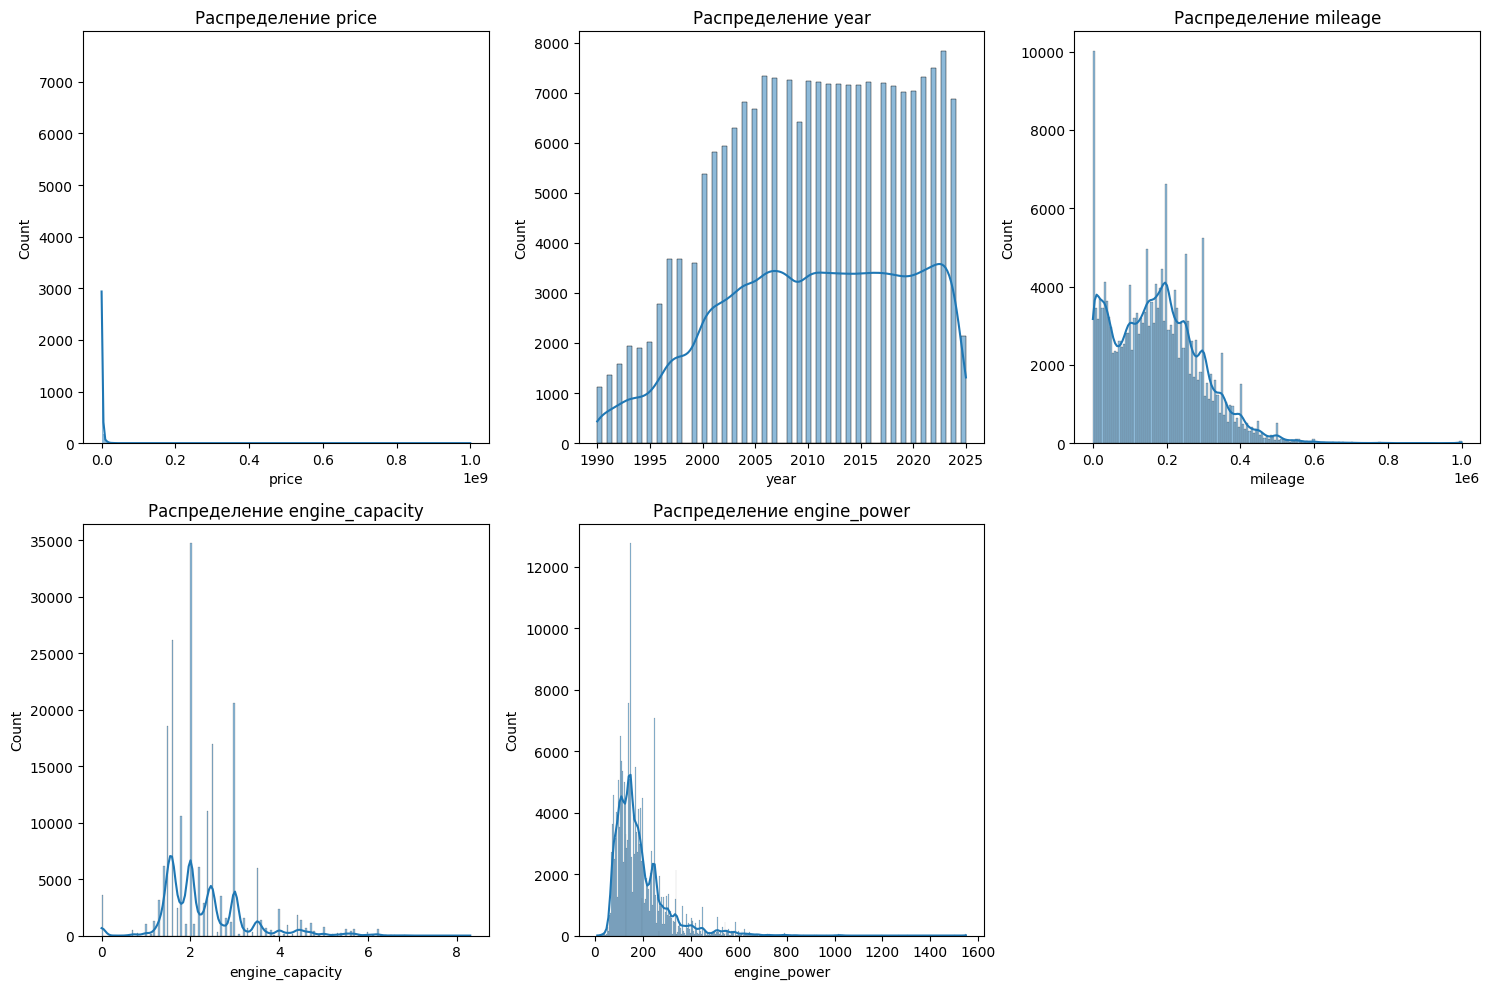

In [121]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

### Посмотрим на распределение числовых признаков в наших данных:
- `price` - подкрепляя данными boxplot выше мы можем заметить, что большинство моделей сконцентрированы в относительно невысоком ценовом диапазоне. Ассиметрия может помешать моделям, в этом случае мы можем прменить преобразование.
- `year` - относительно равномерное с 2020 по 2024 года.
- `mileage` - большинство автомобилей имеет относительно небольшой пробег, а небольшое число — экстремально большой (правостороняя асимметрия). Возможно нужно будет выполнить преобразование.
- `engine_capacity` - распределение также сдвинуто вправо, но в целом меньше «радикальных» выбросов, чем у цены или пробега.
- `engine_power` - аналогично, правосторонняя асимметрия.

## Проанализируем влияение цвета на целевую переменную

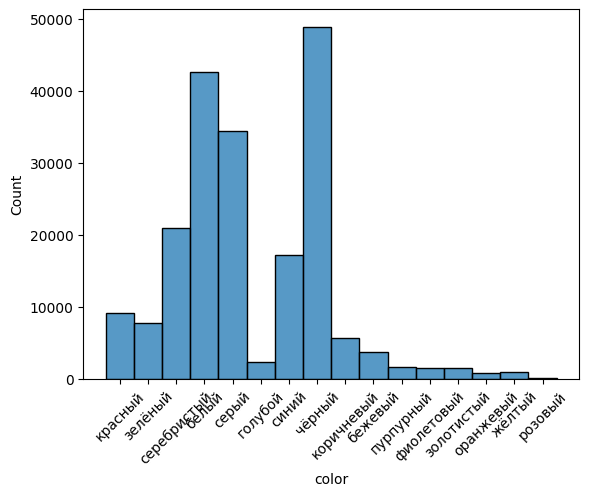

In [122]:
sns.histplot(data=df, x='color')
plt.xticks(rotation=45)
plt.show()

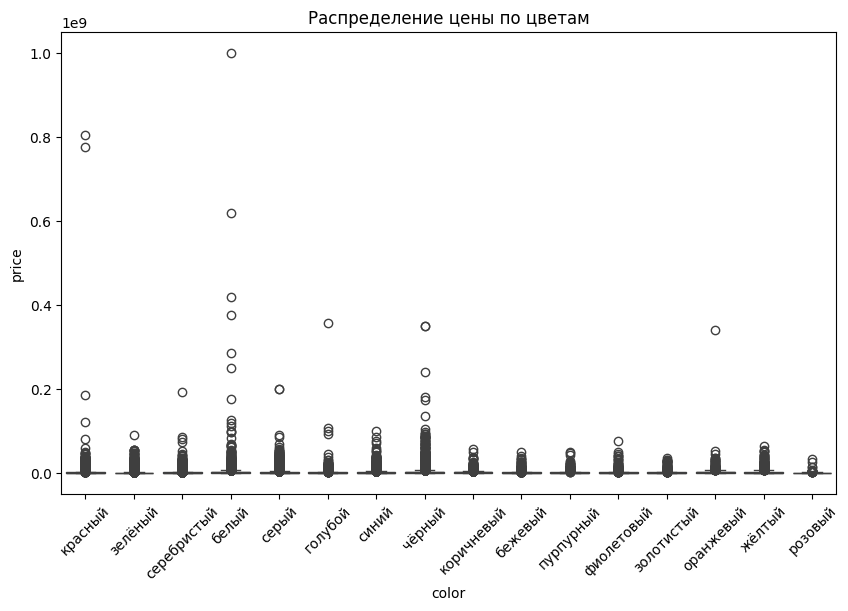

In [123]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='color', y='price', data=df)
plt.title('Распределение цены по цветам')
plt.xticks(rotation=45)
plt.show()

In [124]:
pivot_color = df.pivot_table(
    index='color',
    values='price',
    aggfunc='mean'
)
pivot_color

,price
color,
бежевый,1.364856e+06
белый,2.625883e+06
голубой,2.001075e+06
жёлтый,3.765430e+06
зелёный,1.499662e+06
золотистый,1.542346e+06
коричневый,1.967053e+06
красный,1.813292e+06
оранжевый,3.352920e+06


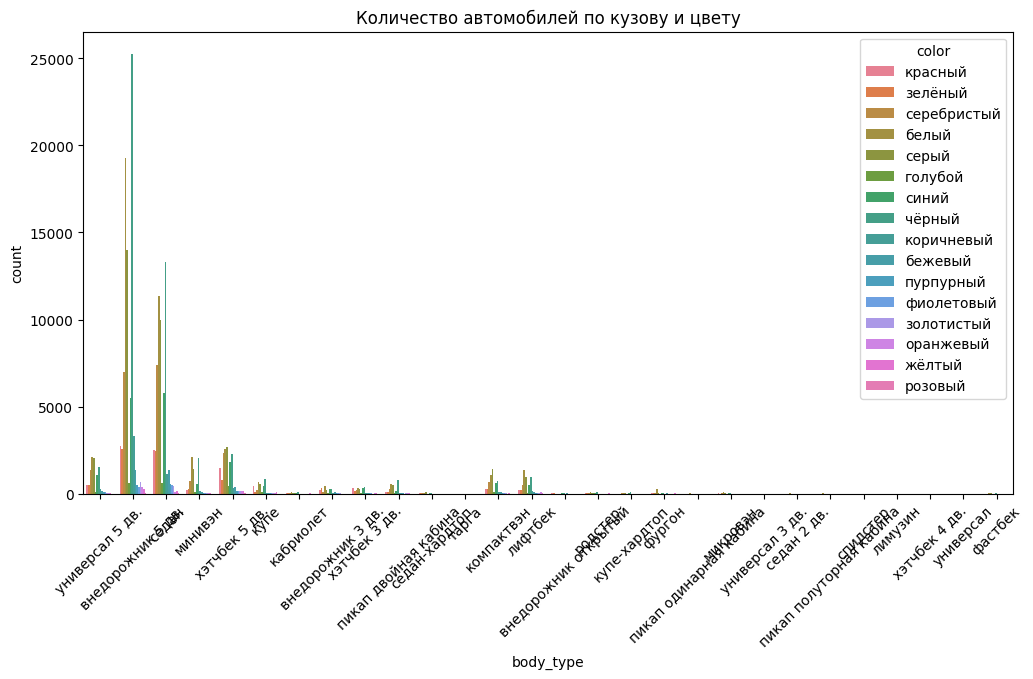

In [125]:

plt.figure(figsize=(12, 6))
sns.countplot(x='body_type', hue='color', data=df)
plt.title('Количество автомобилей по кузову и цвету')
plt.xticks(rotation=45)
plt.show()

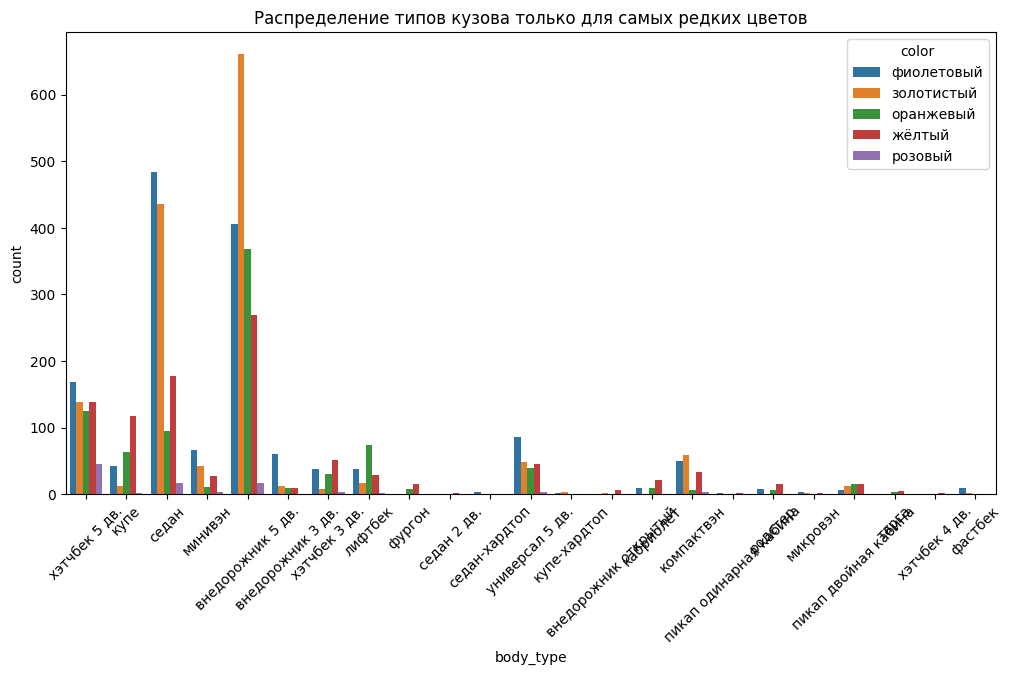

In [126]:
n_rare = 5

color_counts = df['color'].value_counts(ascending=True)
rare_colors = color_counts.index[:n_rare]

df_rare = df[df['color'].isin(rare_colors)]

plt.figure(figsize=(12, 6))
sns.countplot(x='body_type', hue='color', data=df_rare)
plt.title('Распределение типов кузова только для самых редких цветов')
plt.xticks(rotation=45)
plt.show()

In [127]:
ct = pd.crosstab(df['body_type'], df['color'])

ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100
ct_percent = ct_percent.round(2)

threshold = 0

print(ct_percent.where(ct_percent >= threshold))

color                    бежевый  белый  голубой  жёлтый  зелёный  золотистый  \
body_type                                                                       
внедорожник 3 дв.           3.71  21.81     0.91    0.48    14.59        0.58   
внедорожник 5 дв.           1.65  22.95     0.76    0.32     3.04        0.79   
внедорожник открытый        9.35   6.47     6.47    5.04    33.09        1.44   
кабриолет                   0.78  19.96     3.13    4.11     4.11        0.20   
компактвэн                  1.41  19.10     2.21    0.60     4.39        1.08   
купе                        0.36  18.10     2.25    3.24     3.41        0.36   
купе-хардтоп                0.85  19.66     1.71    0.43     2.14        1.28   
лимузин                     0.00  50.00     0.00    0.00     0.00        0.00   
лифтбек                     1.60  26.41     0.93    0.56     4.60        0.33   
микровэн                    2.65  30.68     1.89    0.76     3.03        0.76   
минивэн                     

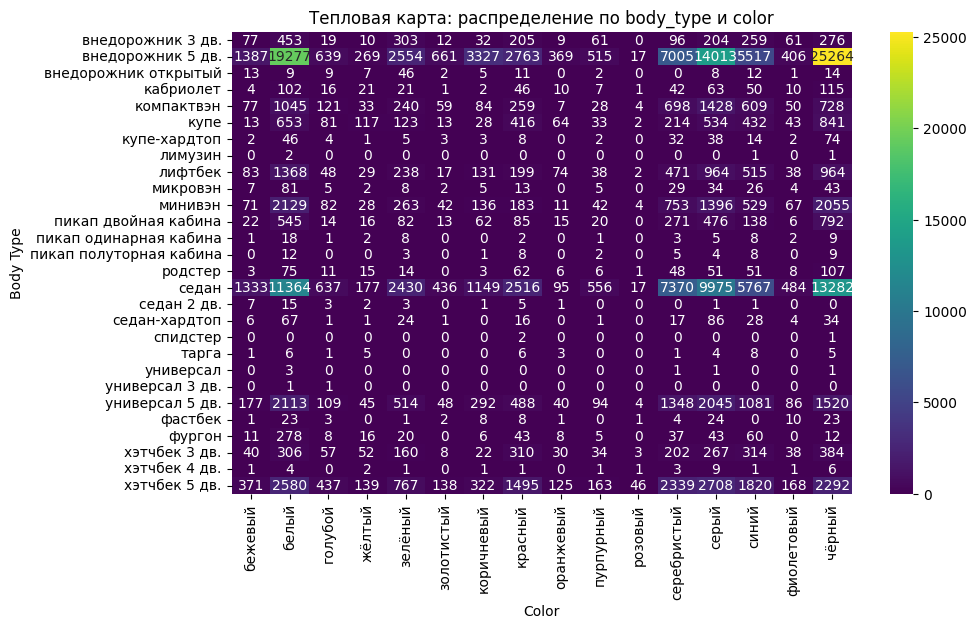

In [128]:
ct = pd.crosstab(df['body_type'], df['color'])

plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt='d', cmap='viridis')
plt.title('Тепловая карта: распределение по body_type и color')
plt.xlabel('Color')
plt.ylabel('Body Type')
plt.show()

Посмотрим, есть ли выбросы в данных среди числовых и категориальных переменных.

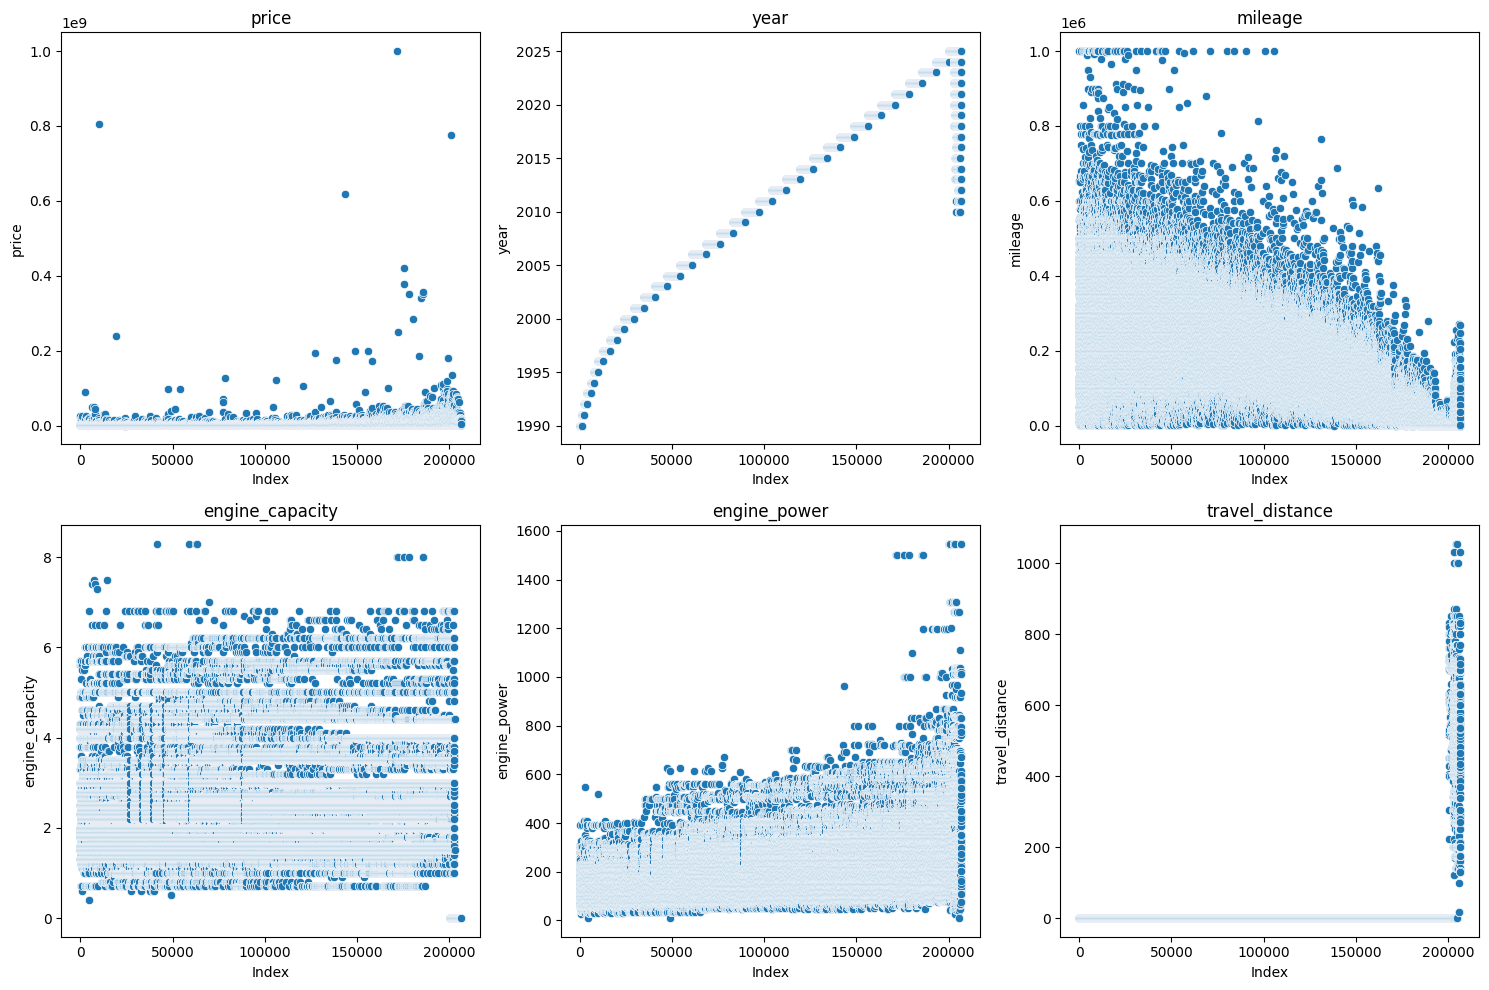

In [129]:
numeric_columns = ['price', 'year', 'mileage', 'engine_capacity', 'engine_power', 'travel_distance']
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df.index, y=df[column])
    plt.title(column)
    plt.xlabel('Index')

plt.tight_layout()
plt.show()

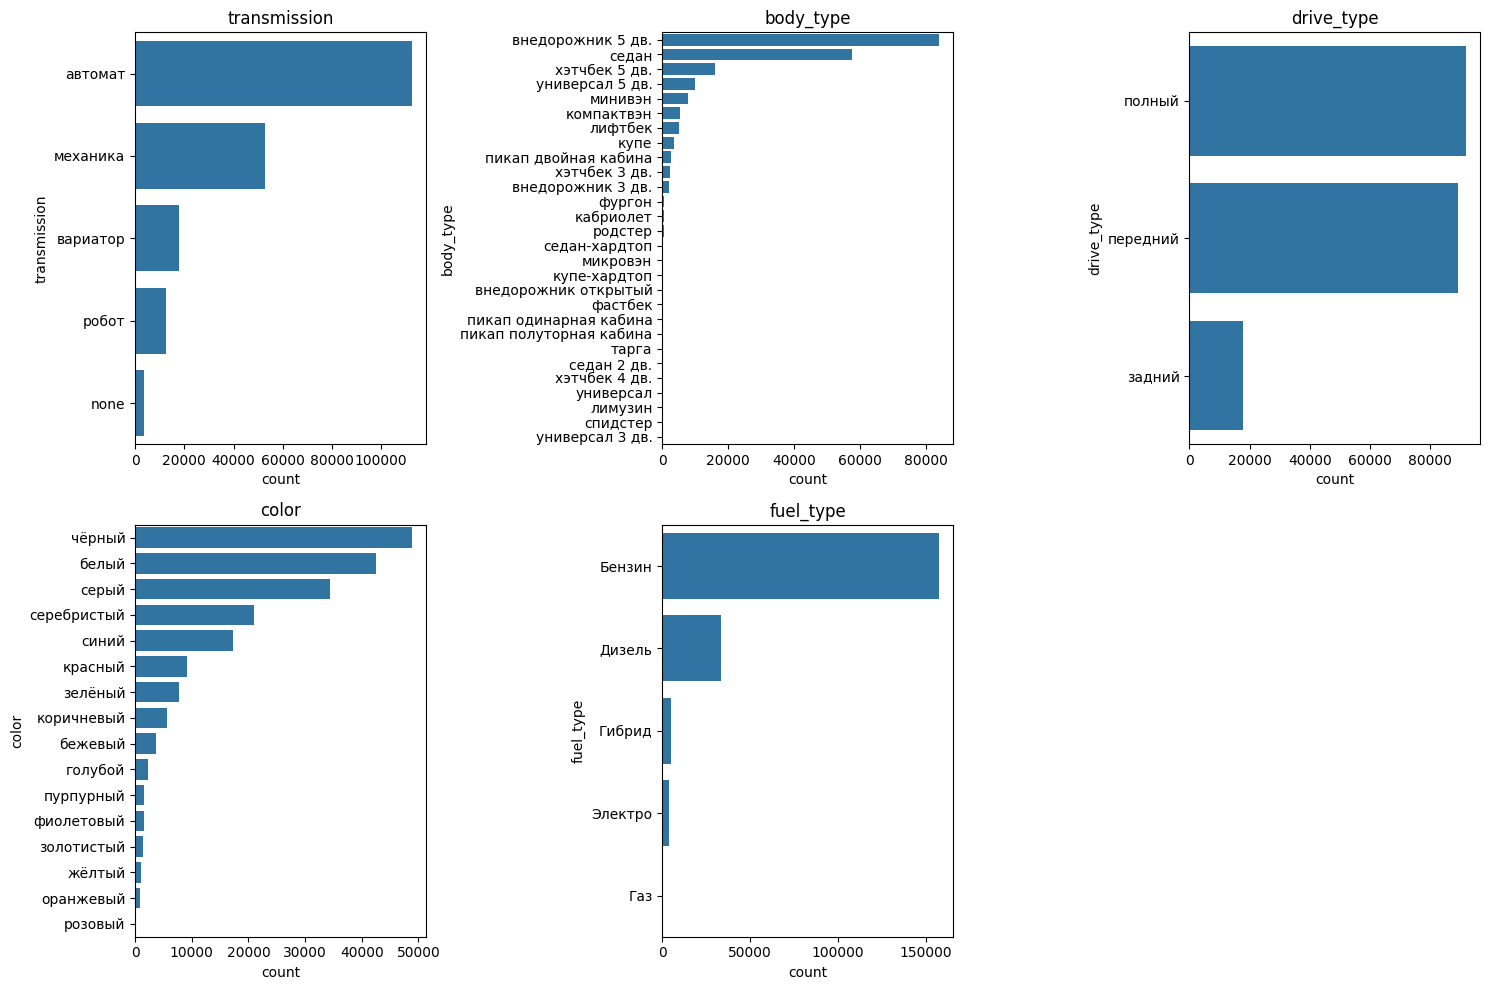

In [130]:
categorical_columns = ['transmission', 'body_type', 'drive_type', 'color', 'fuel_type']


plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=df[column], order=df[column].value_counts().index)
    plt.title(column)

plt.tight_layout()
plt.show()

Видим, что подавляющее большинство авто с бензином, а также видны выбросы в данных. Так как данные имеют нормальное распределение, то используем метод Z-оценки для удаления выбросов.

In [131]:
from scipy.stats import zscore


def remove_outliers_zscore(df, column, threshold=3):
    z_scores = zscore(df[column])
    return df[abs(z_scores) < threshold]


numeric_columns = ['price', 'year', 'mileage', 'engine_capacity', 'engine_power', 'travel_distance']
for column in numeric_columns:
    df = remove_outliers_zscore(df, column)


print(df.shape)


(187694, 12)


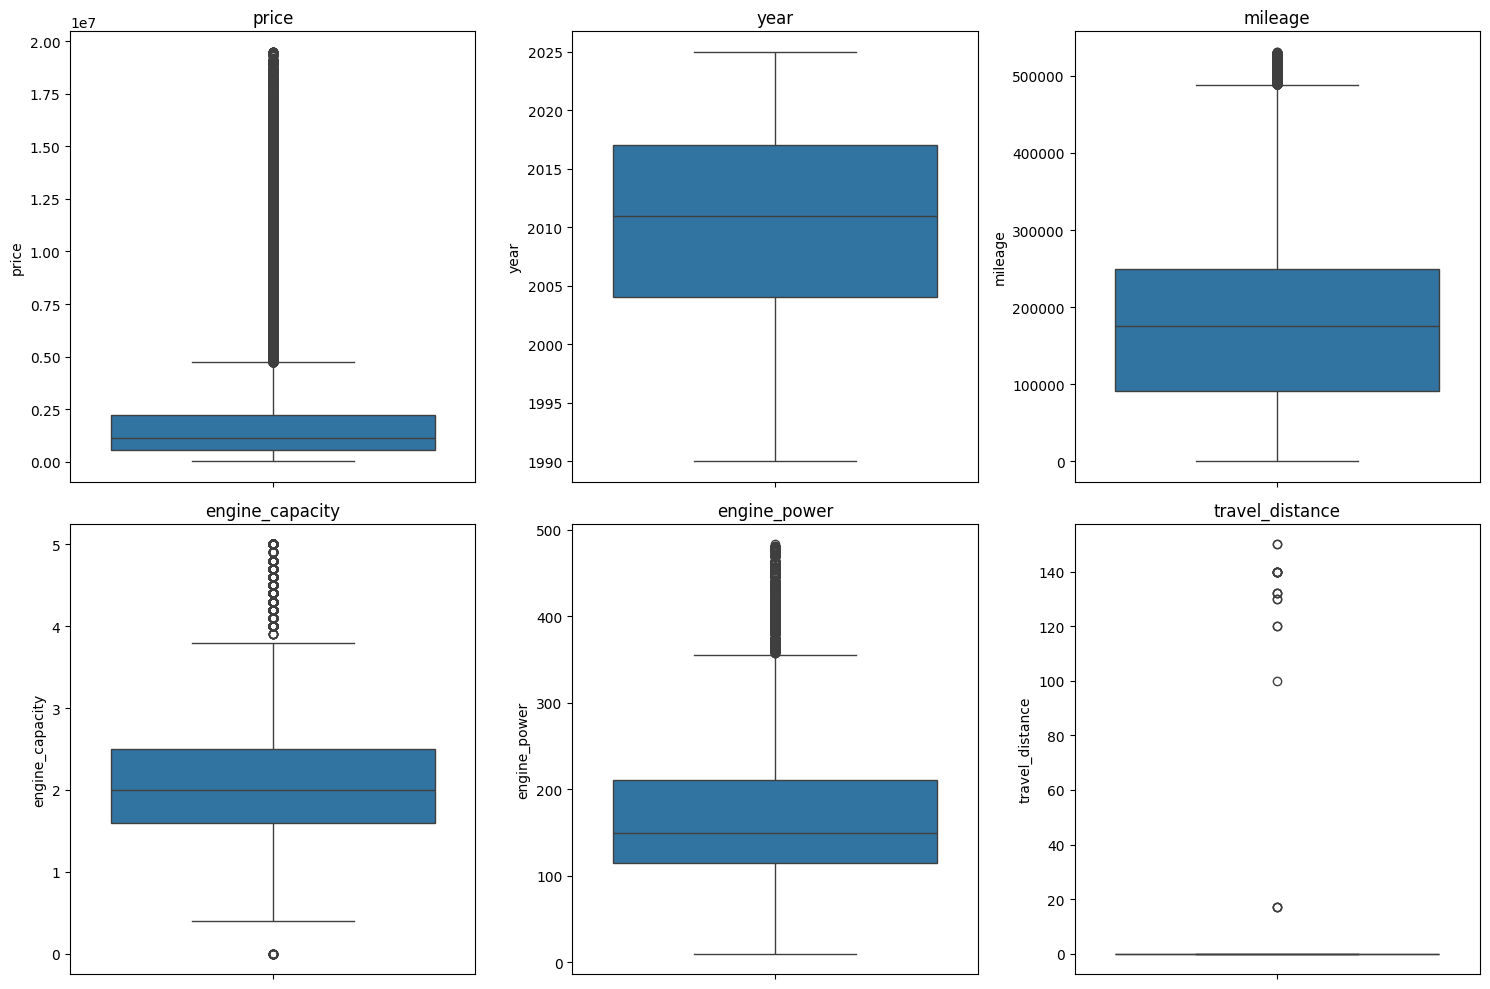

In [133]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

Посмотрим на матрицу корреляций

Матрица корреляций:
                    price      year   mileage  engine_capacity  engine_power  \
price            1.000000  0.596383 -0.492309         0.389585      0.684465   
year             0.596383  1.000000 -0.680341         0.057562      0.419292   
mileage         -0.492309 -0.680341  1.000000         0.066790     -0.241994   
engine_capacity  0.389585  0.057562  0.066790         1.000000      0.725159   
engine_power     0.684465  0.419292 -0.241994         0.725159      1.000000   
travel_distance -0.003452  0.006020 -0.009828        -0.028719     -0.009420   

                 travel_distance  
price                  -0.003452  
year                    0.006020  
mileage                -0.009828  
engine_capacity        -0.028719  
engine_power           -0.009420  
travel_distance         1.000000  


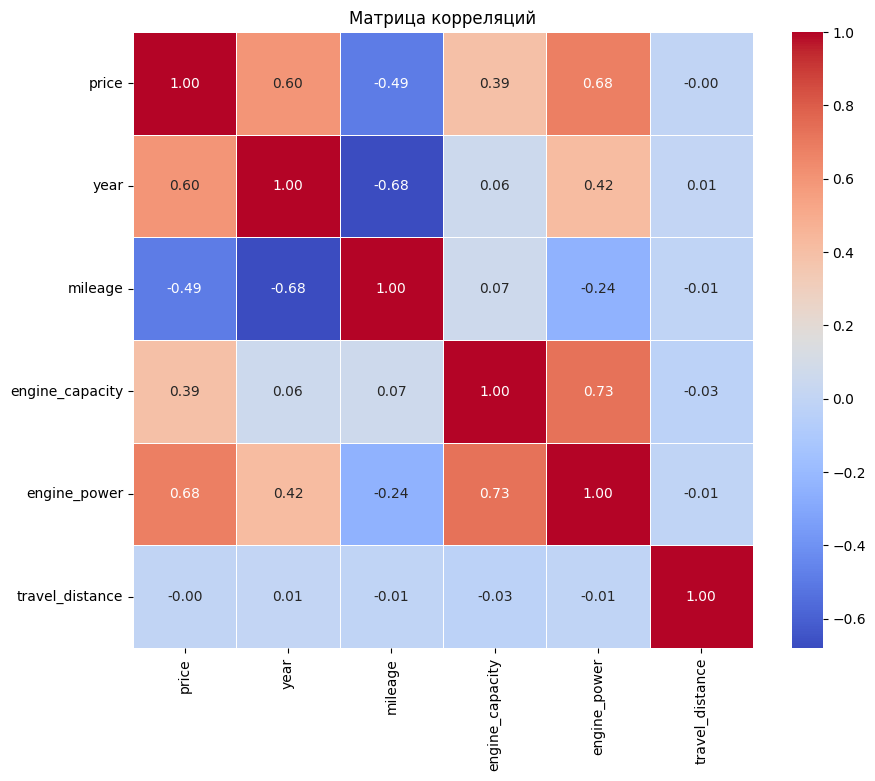

In [134]:
numeric_df = df[numeric_columns]

correlation_matrix = numeric_df.corr()


print("Матрица корреляций:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Матрица корреляций")
plt.show()

Видим, что travel_distance не влияет на цену, поскольку корреляция почти равна 0

Средняя стоимость автомобилей в зависимости от типа топлива:
  fuel_type         price
0    Бензин  1.543280e+06
1       Газ  1.400780e+06
2    Гибрид  4.240002e+06
3    Дизель  3.035709e+06
4   Электро  2.291950e+06


<ipython-input-135-64e71c9fa75f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fuel_type', y='price', data=fuel_price, palette='viridis')


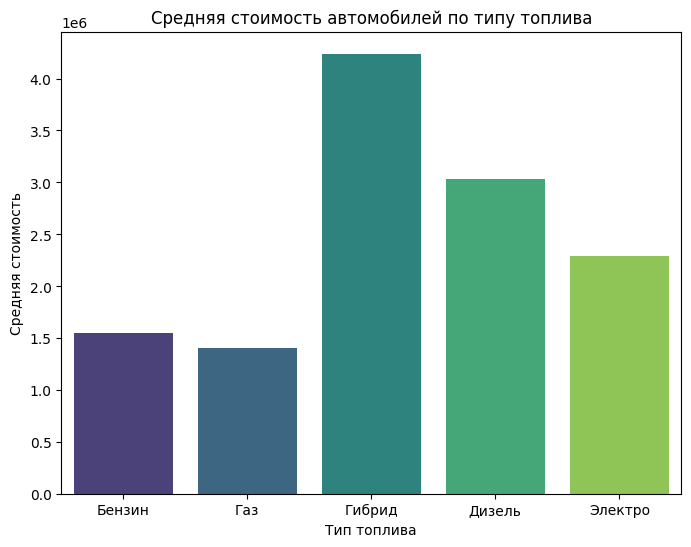

<ipython-input-135-64e71c9fa75f>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fuel_type', y='price', data=df, palette='viridis')


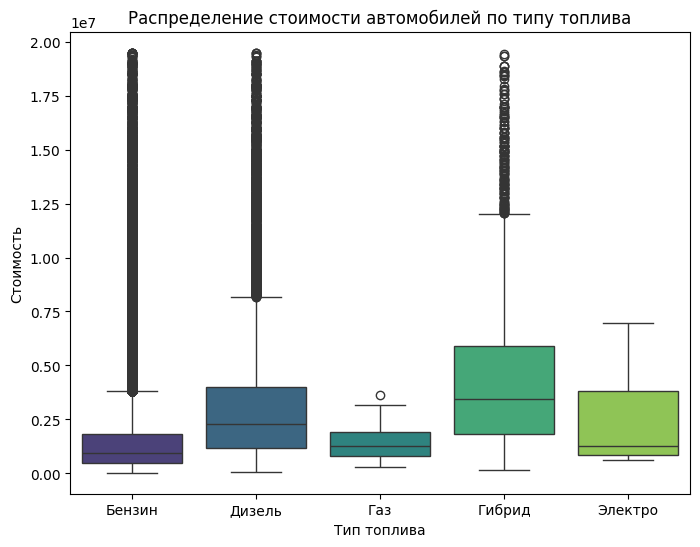

In [135]:
fuel_price = df.groupby('fuel_type')['price'].mean().reset_index()

print("Средняя стоимость автомобилей в зависимости от типа топлива:")
print(fuel_price)

plt.figure(figsize=(8, 6))
sns.barplot(x='fuel_type', y='price', data=fuel_price, palette='viridis')
plt.title('Средняя стоимость автомобилей по типу топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Средняя стоимость')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='fuel_type', y='price', data=df, palette='viridis')
plt.title('Распределение стоимости автомобилей по типу топлива')
plt.xlabel('Тип топлива')
plt.ylabel('Стоимость')
plt.show()

In [136]:
fuel_stats = df.groupby('fuel_type')['price'].agg(['mean', 'median', 'min', 'max']).reset_index()

print("Статистика стоимости автомобилей по типу топлива:")
print(fuel_stats)

Статистика стоимости автомобилей по типу топлива:
  fuel_type          mean     median     min       max
0    Бензин  1.543280e+06   950000.0   25000  19500000
1       Газ  1.400780e+06  1249000.0  265000   3637953
2    Гибрид  4.240002e+06  3440000.0  165000  19438900
3    Дизель  3.035709e+06  2299000.0   45000  19500000
4   Электро  2.291950e+06  1269500.0  600000   6945000


In [137]:
from sklearn.preprocessing import StandardScaler


numeric_columns = ['price', 'year', 'mileage', 'engine_capacity', 'engine_power', 'travel_distance']
numeric_df = df[numeric_columns]


scaler = StandardScaler()


scaled_data = scaler.fit_transform(numeric_df)

scaled_df = pd.DataFrame(scaled_data, columns=numeric_columns)

for column in numeric_columns:
    df[column + '_scaled'] = scaled_df[column]

print(df.head())

    price                   title  year  mileage transmission  \
3  189700    Volkswagen Passat B3  1990   325000     механика   
4  370000        Nissan Terrano I  1990   224000      автомат   
5  350000          Honda Civic IV  1990   200000     механика   
6  360000    Volkswagen Passat B3  1990   200000     механика   
7   99000  Toyota Carina V (T170)  1990   296000      автомат   

           body_type drive_type        color  engine_capacity  engine_power  \
3    универсал 5 дв.   передний      красный              1.8          90.0   
4  внедорожник 5 дв.     полный      зелёный              2.7         100.0   
5              седан   передний  серебристый              1.6         120.0   
6    универсал 5 дв.   передний        белый              1.8          90.0   
7              седан   передний  серебристый              1.5          94.0   

  fuel_type  travel_distance  price_scaled  year_scaled  mileage_scaled  \
3    Бензин                0     -0.665920    -2.347565    

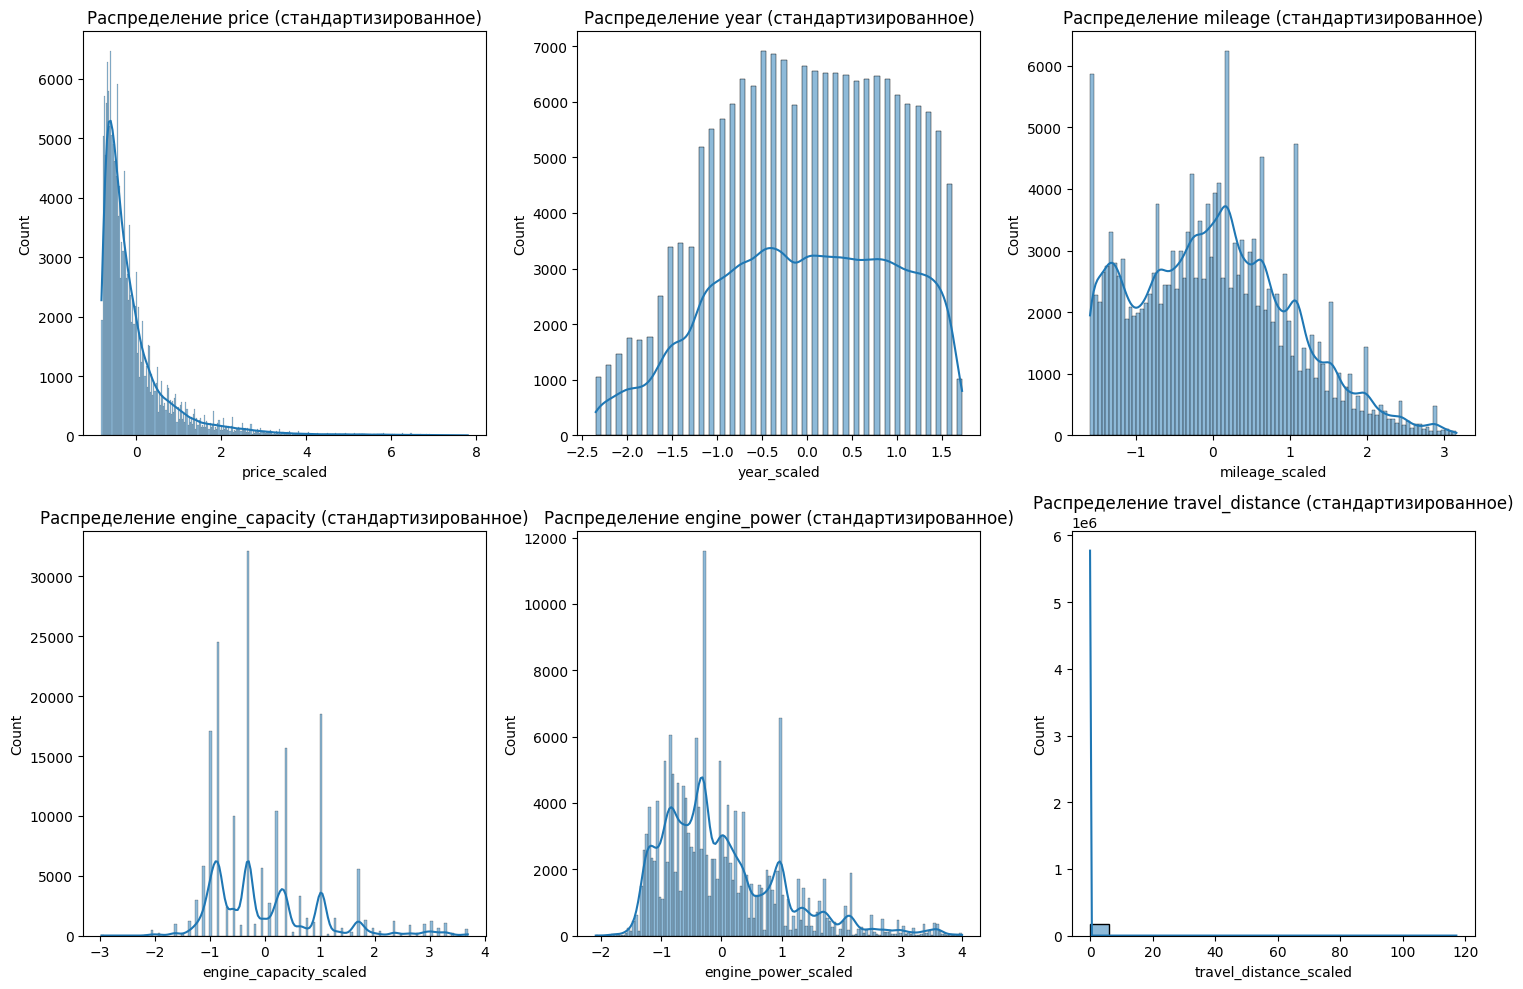

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[column + '_scaled'], kde=True)
    plt.title(f'Распределение {column} (стандартизированное)')

plt.tight_layout()
plt.show()